# 0.0.IMPORTS

In [1]:
import math 
import datetime
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns



from scipy                import stats as ss
from tabulate             import tabulate
from matplotlib           import pyplot as plt
from IPython.display      import Image
from IPython.core.display import HTML


## 0.1.HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.stlye.use ('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>. container {width: 100% !importante; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    

def cramer_v (x,y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = ss.chi2_contingency (cm) [0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )


## 0.2.LOADING DATA


In [3]:
df_sales_raw  = pd.read_csv ( 'data/train.csv', low_memory=False)
df_stores_raw = pd.read_csv ( 'data/store.csv', low_memory=False)

#MERGE DE DADOS
df_raw = pd.merge ( df_sales_raw, df_stores_raw, how= 'left', on= 'Store' )

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DESCRICAO DOS DADOS

## 1.1 RENAME COLUMNS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list( map( snakecase, cols_old) )

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 DIMENSIONS

In [9]:
##shape 0 = linhas     1 = colunas

print('Number of Rows: {}'.format ( df1.shape[0] ) )
print('Number of Columns: {}'.format ( df1.shape[1] ) )


Number of Rows: 1017209
Number of Columns: 18


## 1.3 DATA TYPES

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 CHECK NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 FILLOUT NA

In [12]:
df1 ['competition_distance'].max()

75860.0

In [13]:
#competition_distance    
df1['competition_distance'] = df1 ['competition_distance'].apply( lambda x: 20000.0 if math.isnan (x)  else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x ['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year    
df1['competition_open_since_year'] = df1.apply( lambda x: x ['date'].year 
                                               if math.isnan( x['competition_open_since_year'] ) 
                                               else x['competition_open_since_year'], axis = 1 )

#promo2_since_week             

df1['promo2_since_week'] = df1.apply( lambda x: x ['date'].week 
                                     if math.isnan( x['promo2_since_week'] ) 
                                     else x['promo2_since_week'], axis = 1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x ['date'].year 
                                     if math.isnan( x['promo2_since_year'] ) 
                                     else x['promo2_since_year'], axis = 1 )

#promo_interval          
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0,inplace =  True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

#promo_interval - Se a promo está dentro do intervalo indicado
df1['is_promo'] = df1[['month_map', 'promo_interval']].apply( lambda x:  0 
                                                             if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split (',') 
                                                             else 0, axis = 1)

## 1.6. CHANGE TYPES

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
#Mudar os tipos dos dados das colunas

df1['competition_open_since_month']  = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year']   = df1['competition_open_since_year'].astype (int)
df1['promo2_since_week']             = df1['promo2_since_week'].astype (int)
df1['promo2_since_year']             = df1['promo2_since_year'].astype (int)

## 1.7. DESCRIPTIVE STATISTICAL

In [16]:
#Separar variaveis numéricas e categórigas
num_attributes = df1.select_dtypes( include = ['int32', 'int64' , 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64' , 'float64', 'datetime64[ns]'] )

In [17]:
#Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply ( np.mean  ) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median) ).T


#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


#Concatenate 
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m.head(9)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5467.928135,2330.0,7740.896804,2.894723,12.724442
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607


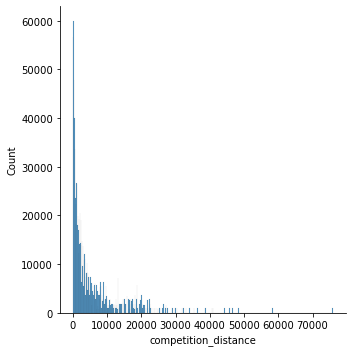

In [19]:
sns.displot(df1['competition_distance'])

In [20]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [21]:
#variáveis categóricas sendo analisadas por boxplot.
cat_attributes.apply ( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

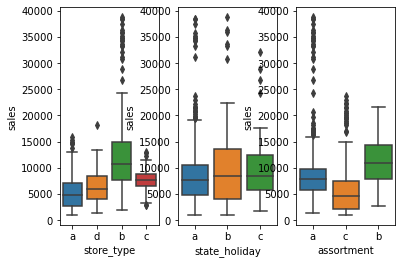

In [22]:
aux1 = df1 [ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ] 

plt.subplot(1,3,1)
sns.boxplot( x= 'store_type', y= 'sales' , data= aux1 )

plt.subplot(1,3,2)
sns.boxplot( x= 'state_holiday', y= 'sales' , data= aux1 )

plt.subplot(1,3,3)
sns.boxplot( x= 'assortment', y= 'sales' , data= aux1 )

In [23]:
df1.sample(5).T

,420959,907596,34005,489599,95999
store,275,772,556,900,110
day_of_week,4,2,3,6,3
date,2014-06-19 00:00:00,2013-04-09 00:00:00,2015-07-01 00:00:00,2014-04-19 00:00:00,2015-05-06 00:00:00
sales,0,3073,9811,4877,4311
customers,0,424,945,505,587
open,0,1,1,1,1
promo,1,1,1,0,1
state_holiday,a,0,0,0,0
school_holiday,1,0,0,0,0
store_type,d,d,d,a,a


In [24]:
df2 = df1.copy()

# 2.0 Feature Engeneering

## 2.1. Mapa Mental de Hipóteses 

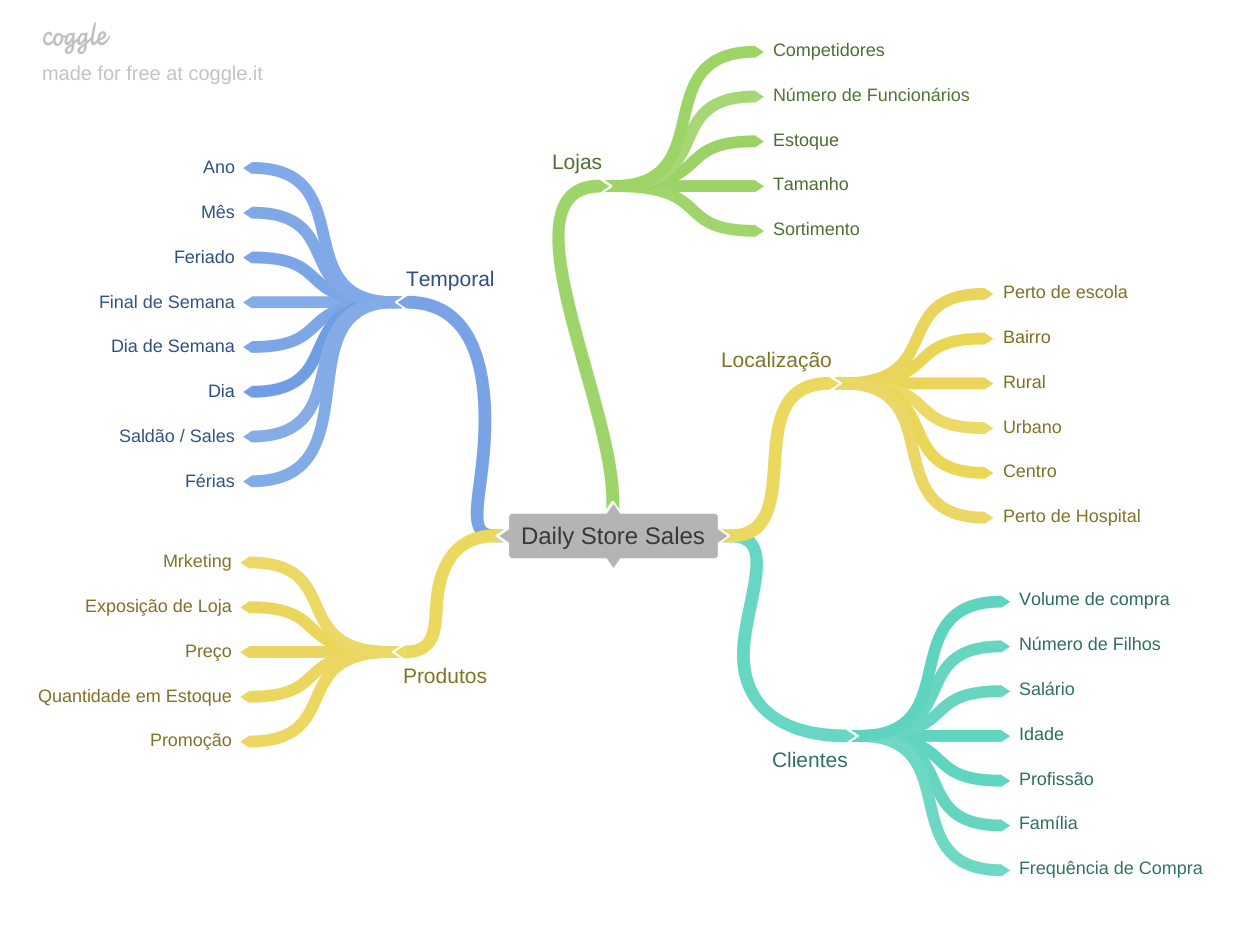

In [25]:
Image('image/Minmap_hipotese.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Hipótese de Loja

**1.** Lojas com maior quadro de funcionários deveriam vernder mais. 

**2.** Lojas com maior estoque deveriam vender mais. 

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender mais.

**5.** Lojas com maior sortimento deveriam vender mais. 

**6.** Lojas com competidores à mais tempo deveriam vender mais

**7.** Lojas com competidores mais próximos deveriam vender menos

### 2.2.2. Hipótese de Produtos

**1.** Lojas que investem mais em marketing, deveriam vender mais

**2.** Lojas que expõem mais os produtos na vitrine, deveriam vender mais

**3.** Lojas que tem preços menores, deveriam vender mais

**4.** Lojas que tem preços menores deveriam vender mais

**5.** Lojas com promoçao mais agressiva (descontos maiores), deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo, deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3. Hipótese de Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais. 

**2.** Lojas com competidores à mais tempo deveriam vender mais

**3.** Lojas com competidores mais próximos deveriam vender menos

**4.** Lojas com competidores a mais tempo deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo, deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais

**9.** Lojas deveriam vender mais ao longo dos anos

**10.** Lojas deveriam vender mais no segundo semestre do ano

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês

**12.** Lojas deveriam vender menos aos finais de semana

**13.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2 ['date'].dt.year
# month
df2['month'] = df2 ['date'].dt.month
# day
df2['day'] = df2 ['date'].dt.day
# week of the year
df2['week_of_year'] = df2 ['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2 ['date'].dt.strftime('%Y-%W')

# competittion since
df2['competition_since'] =  df2.apply (lambda x: datetime.datetime ( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1 ), axis = 1 ) 
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days).astype (int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta ( days=7))
df2['promo_time_week']=  ((df2['date'] - df2['promo_since'])/7).apply (lambda x: x.days ).astype(int)

# assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

## 3.1. SELECAO DE LINHAS

In [28]:
df3 = df2.copy()

In [29]:
df3 = df3[(df3['open']  != 0) & (df3['sales'] >  0)]

## 3.1. SELECAO DE COLUNAS

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA

In [32]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

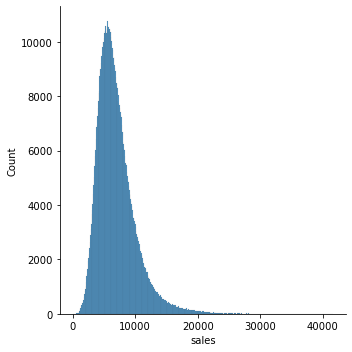

In [33]:
sns.displot(df4['sales'])

### 4.1.2. Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

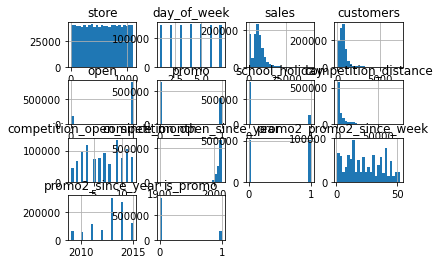

In [34]:
num_attributes.hist(bins = 25)

### 4.1.3. Categorical Variable

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\kendi\Anaconda3\envs\ML38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\kendi\Anaconda3\envs\ML38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\kendi\Anaconda3\envs\ML38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

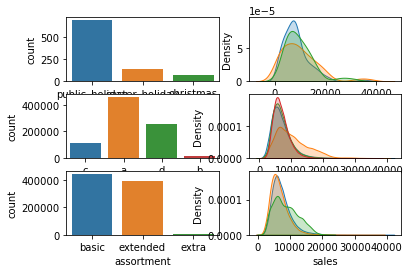

In [37]:
##state_holiday
plt.subplot ( 3,2,1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])

plt.subplot ( 3,2,2 )
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot ( 3,2,3 )
sns.countplot( df4['store_type'])

plt.subplot ( 3,2,4 )
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

##assortment
plt.subplot ( 3,2,5 )
sns.countplot( df4['assortment'])

plt.subplot ( 3,2,6 )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

C:\Users\kendi\Anaconda3\envs\ML38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\kendi\Anaconda3\envs\ML38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='year_week'>

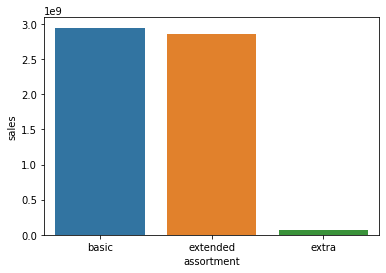

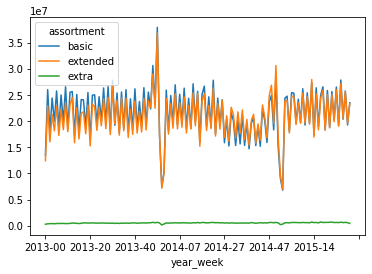

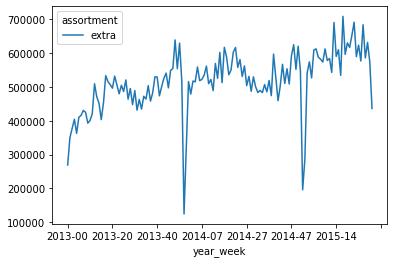

In [38]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment').sum().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week', 'assortment' ,'sales']].groupby( ['year_week' , 'assortment'] ).sum().reset_index() 
aux2.pivot ( index = 'year_week', columns = 'assortment' , values = 'sales').plot()

## plotado separadamente devido a escala - observar melhor como as vendas do tipo extra ocorre. 
aux3 = aux2[aux2 ['assortment'] == 'extra']
aux3.pivot ( index = 'year_week', columns = 'assortment' , values = 'sales').plot()

### H2. Lojas com competidores à mais tempo deveriam vender mais
**FALSA**  Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

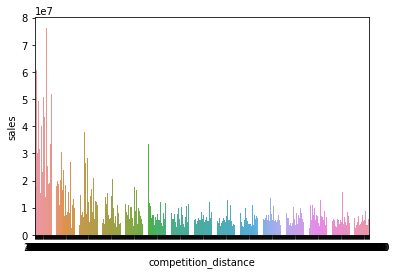

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x= 'competition_distance', y='sales', data=aux1);

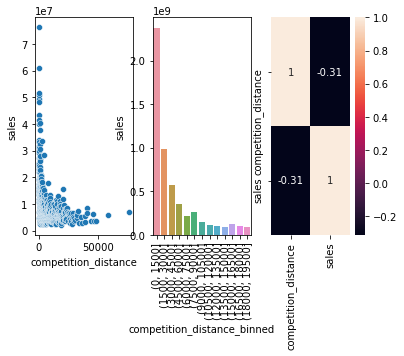

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1,3,1)
sns.scatterplot( x= 'competition_distance', y= 'sales', data = aux1);

plt.subplot (1,3,2)
bins = list(np.arange (0,20000, 1500) )
aux1['competition_distance_binned'] =  pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y='sales', data=aux2);
plt.xticks (rotation = 90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

In [41]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
190,2190.0,14929271,"(1500, 3000]"
109,1190.0,14397463,"(0, 1500]"
454,8670.0,3108353,"(7500, 9000]"
135,1500.0,9364281,"(0, 1500]"


### H3. Lojas com competidores há mais tempo deveriam vender mais
**FALSA**  Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS

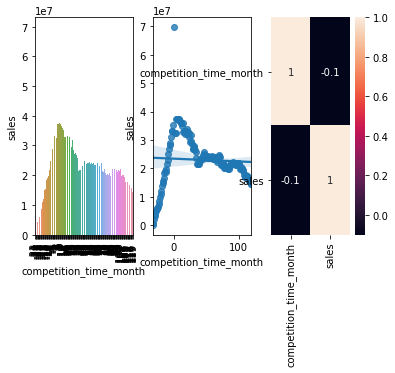

In [42]:
plt.subplot(1,3,1)
aux1 = df4 [['competition_time_month', 'sales']].groupby ('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1 ['competition_time_month'] < 120 ) & ( aux1 ['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month' , y='sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month' , y= 'sales', data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
**FALSA**  Lojas compromocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

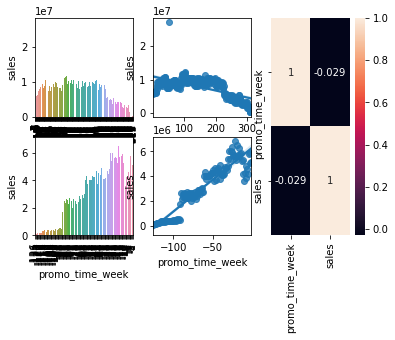

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1 [aux1['promo_time_week'] > 0] #promo extendido
sns.barplot (x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot(grid[0,1])
sns.regplot (x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1 [aux1['promo_time_week'] < 0] #promo regular
sns.barplot (x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[1,1])
sns.regplot (x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### <s> H5.  Lojas com mais dias de promoção deveriam vender mais <s>

### H7. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com promocoes consecutivas vendem menos 

In [44]:
df4[['promo', 'promo2', 'sales']].groupby( [ 'promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


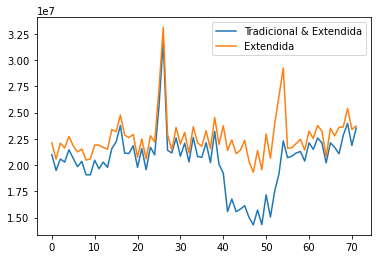

In [45]:
aux1 = df4[( df4 ['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4 ['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas vendem menos no feriado de natal

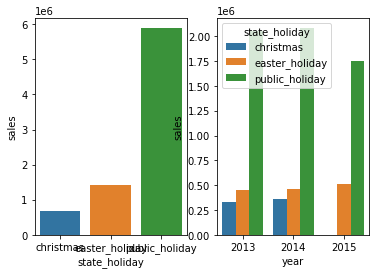

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x= 'state_holiday', y ='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x= 'year', y= 'sales', hue = 'state_holiday', data= aux2 );



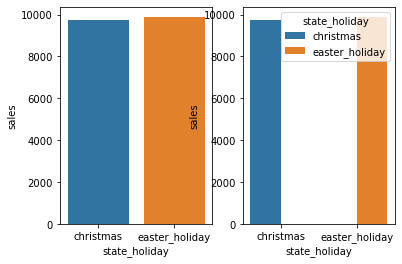

In [47]:
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['state_holiday'] != 'public_holiday')]

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot( x= 'state_holiday', y ='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[[ 'state_holiday', 'sales']].groupby( [  'state_holiday'] ).mean().reset_index()
sns.barplot( x= 'state_holiday', y= 'sales', hue = 'state_holiday', data= aux2 );



### H9. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

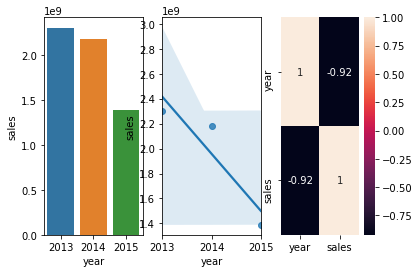

In [48]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

In [49]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data = aux1);

plt.subplot(1,3,3)c
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

SyntaxError: invalid syntax (<ipython-input-49-0db72f2c39cd>, line 9)

### H10.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H11.** Lojas deveriam vender mais depois do dia 10 de cada mês
**Verdadeiro** Lojas vendem mais após o dia 10

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y='sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y='sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);

### H12.** Lojas deveriam vender menos aos finais de semana
**Verdadeiro** Lojas vendem menos nos finais de semana

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H13.** Lojas deveriam vender menos durante os feriados escolares
**Verdadeiro** Lojas vendem vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y='sales', data = aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y='sales', hue='school_holiday' ,data = aux2);

### 4.2.1. Resumo das Hipóteses 

In [ ]:
tab = [['Hipotese', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', ' -', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],     
      ]
print(tabulate (tab, headers = 'firstrow'))

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [ ]:
##person - categorias numericas 
correlation  =  num_attributes.corr(method = 'pearson')
sns.heatmap (correlation, annot = True);

### 4.3.1. Categorical Attributes

In [ ]:
#Only Categorical Data
a = df4.select_dtypes ( include = 'object')

#Calculate Cramer_v

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame ({'state_holiday': [a1,a2,a3],
               'store_type': [a4,a5,a6],
               'assortment': [a7,a8,a9]})

d=d.set_index(d.columns)

In [ ]:
sns.heatmap(d, annot = True)

# 5.0. ENCODING

## 5.1. Analise Univariada

### 5.1.1. Categorical Attributes